## Import libraries

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import keras
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline 
import sys
import os
# Train test validation Split
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from wandb.keras import WandbCallback
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model

## Set initial parameters

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 100
MAX_NB_WORDS = 200000
VALIDATION_SPLIT = 0.2

## Load the Dataset

In [ ]:
    
#clean the dataset
def clean_str(string):
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()


#read the training data
train_data = pd.read_csv('train.csv')
train_data.text[1]

train_data

train_data['label'].value_counts()


print(train_data.columns)
print('The raw input data looks like: ')
print(train_data[0:5])

## Vectorize the data

In [ ]:
labels =[]
train_data_text =[] 

for index in range(train_data.text.shape[0]):
    text1 = train_data.title[index]
    text2 = train_data.text[index]
    combined_text = str(text1) +""+ str(text2)
    train_data_text.append(combined_text)
    labels.append(train_data.label[index])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_data_text)
sequences = tokenizer.texts_to_sequences(train_data_text)

word_index = tokenizer.word_index
print('There are %s unique tokens.' % len(word_index))



# Pad the input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

## Split the data and apply embeddings

In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( data, labels, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('Real and fake news in train,validation and test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

#Used Pre-trained word Glove embeddings
GLOVE_DIR = "data" 
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[index] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

In [ ]:
!pip install wandb

!wandb login

## Build the CNN model

In [ ]:
# custom CNN model
import wandb
from keras.layers import Dropout
input_sequence = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(input_sequence)

#Add first convolutional layer
covolution1= Conv1D(128, 5, activation='relu')(embedded_sequences)
pool1 = MaxPooling1D(5)(covolution1)

#Add dropout layer
dropout1 = Dropout(0.2)(pool1)

#Add second convolutional layer
covolution2 = Conv1D(128, 5, activation='relu')(pool1)
pool2 = MaxPooling1D(5)(covolution2)

#Add dropout layer
dropout2 = Dropout(0.2)(pool2)

#Add third convolutional layer
covolution3 = Conv1D(128, 5, activation='relu')(pool2)
pool3 = MaxPooling1D(35)(covolution3)  # global max pooling

#Add fourth layer
l_flat = Flatten()(pool3)

#Add two dense layers
l_dense = Dense(128, activation='relu')(l_flat)
dropout3 = Dropout(0.2)(l_dense)
predictions = Dense(2, activation='softmax')(l_dense)

#Use wandb to display training accuracy and loss graphs
wandb.init(project="FakeNews")
config = wandb.config
config.learning_rate = 0.01

model = Model(input_sequence, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

print("Fitting the convolutional neural network model")
model.summary()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=3, batch_size=128,callbacks=[WandbCallback()])

#!wandb login --relogin

## Save the model and plot its metrics

In [ ]:
import joblib
model_filename = "cnnepochs3.pkl"
joblib.dump(history.history, model_filename)

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test the model

In [ ]:
# Test the model

from sklearn.metrics import accuracy_score

# Test the model
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).flatten()
accuracy = accuracy_score(y_test.flatten(), y_pred)
print(f"Correct number of predictions obtained: {accuracy * len(y_test)}")
print(f"Total number of test examples: {len(y_test)}")
print(f"Accuracy of model: {accuracy:.2%}")

## Obtain Metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Index(['id', 'title', 'author', 'text', 'label'], dtype='object')
The raw input data looks like: 
   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nA

acc,▁▇█
epoch,▁▅█
loss,█▄▁
val_acc,▁▇█
val_loss,█▄▁
acc,0.63185
best_epoch,2
best_val_loss,0.64234
epoch,2
loss,0.64942
val_acc,0.64115


Fitting the convolutional neural network model
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 1000, 100)         25187700  
                                                                 
 conv1d_9 (Conv1D)           (None, 996, 128)          64128     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 199, 128)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 195, 128)          82048     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 39, 128)          0         
 g1D)       

wandb: Adding directory to artifact (/content/wandb/run-20230503_021659-jyxf7bf8/files/model-best)... Done. 1.5s


130/130 [==============================] - 202s 2s/step - loss: 0.6708 - acc: 0.6000 - val_loss: 0.6617 - val_acc: 0.6287
Epoch 2/3
130/130 [==============================] - ETA: 0s - loss: 0.6587 - acc: 0.6209

wandb: Adding directory to artifact (/content/wandb/run-20230503_021659-jyxf7bf8/files/model-best)... Done. 1.6s


130/130 [==============================] - 190s 1s/step - loss: 0.6587 - acc: 0.6209 - val_loss: 0.6508 - val_acc: 0.6382
Epoch 3/3
130/130 [==============================] - ETA: 0s - loss: 0.6499 - acc: 0.6329

wandb: Adding directory to artifact (/content/wandb/run-20230503_021659-jyxf7bf8/files/model-best)... Done. 1.6s


130/130 [==============================] - 210s 2s/step - loss: 0.6499 - acc: 0.6329 - val_loss: 0.6430 - val_acc: 0.6463
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


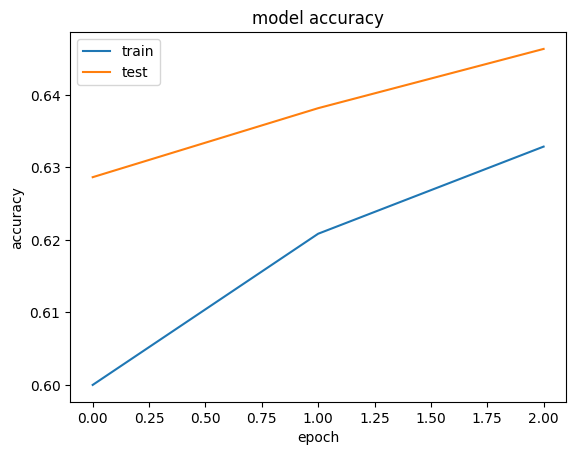

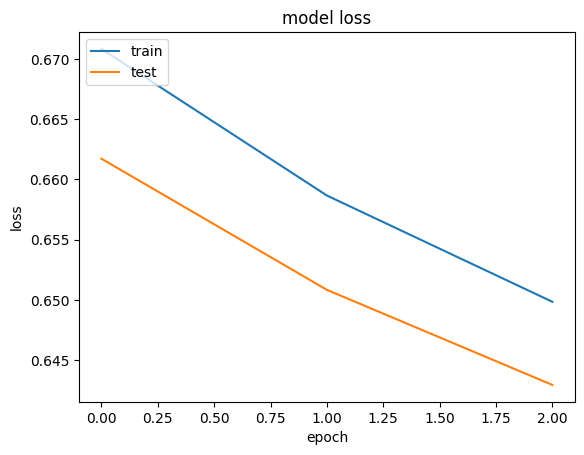

325/325 [==============================] - 21s 63ms/step
Correct number of predictions obtained: 6602.0
Total number of test examples: 10400
Accuracy of model: 63.48%
325/325 [==============================] - 21s 63ms/step
Test accuracy of the model: 0.6348077058792114
Test loss of the model: 0.6468451023101807
              precision    recall  f1-score   support

           0       0.53      0.50      0.51      5454
           1       0.48      0.51      0.49      4946

   micro avg       0.50      0.50      0.50     10400
   macro avg       0.50      0.50      0.50     10400
weighted avg       0.50      0.50      0.50     10400
 samples avg       0.50      0.50      0.50     10400



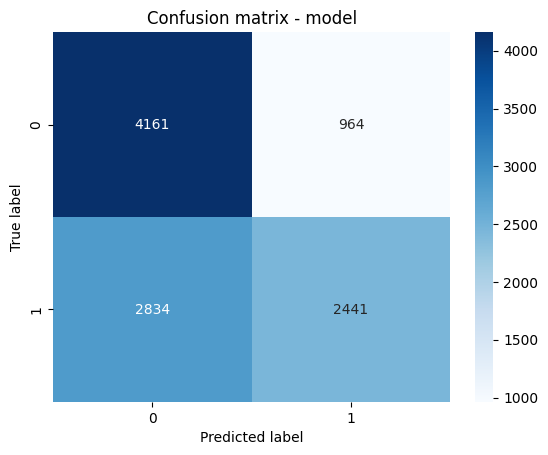

In [11]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on test set and get the class with highest probability
y_pred = np.argmax(model.predict(x_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)

# Plot confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion matrix - model')
plt.xlabel('Predicted label')
plt.ylabel('True label')

#Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)

#Display test accuracy and loss
print('Test accuracy of the model:', score[1])
print('Test loss of the model:', score[0])

#Display the classification report
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(test_predictions,y_test))

In [ ]:
#### 5 epochs